In [1]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
df_train = pd.read_csv('/kaggle/input/i2a2-brasil-pneumonia-classification/train.csv')
df_train.head()

fileName  pneumonia
0  ceba102d-27ba-4592-a0a6-60b217a94aa1.jpeg          0
1  7c05f8d3-57d4-4e4d-8dcd-7ae57699708c.jpeg          1
2  62914667-284b-4600-a14a-e22b19e8259b.jpeg          1
3  9a6d49e0-0996-420a-921b-8d9a8a37fca5.jpeg          1
4  ce0c8c09-3816-4ccc-95ae-68c3cf1344c7.jpeg          1

In [3]:
positive = df_train.query('pneumonia == 1')
print(len(positive))

negative = df_train.query('pneumonia == 0')
print(len(negative))

2991
1108


In [4]:
def show_images(df):
    for filename in df['fileName']:
      image = mpimg.imread(f"/kaggle/input/i2a2-brasil-pneumonia-classification/images/{filename}")
      imgplot = plt.imshow(image)
      plt.show()

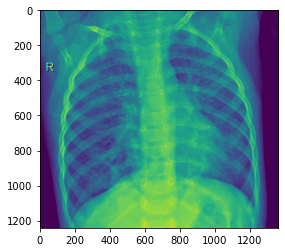

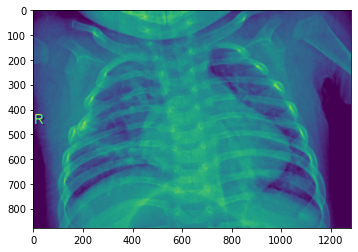

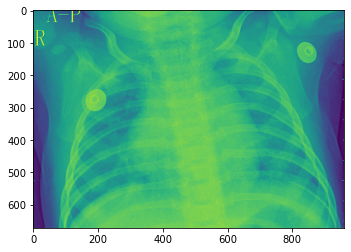

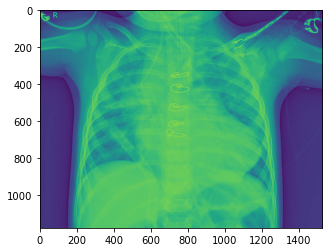

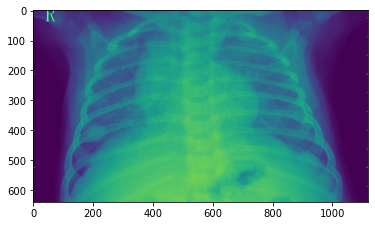

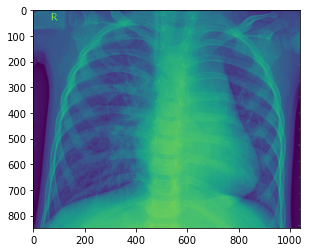

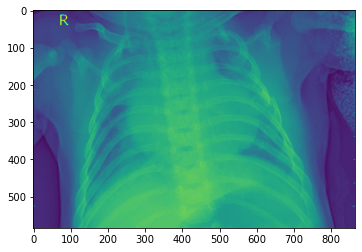

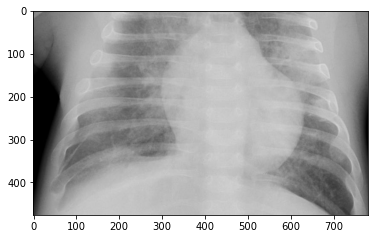

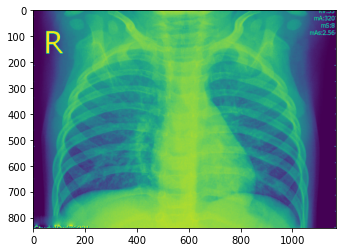

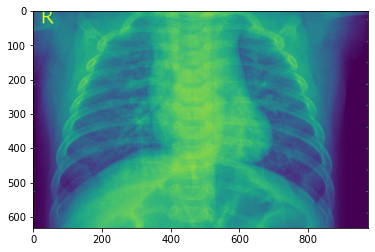

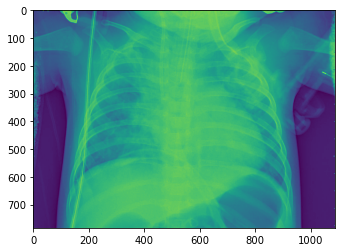

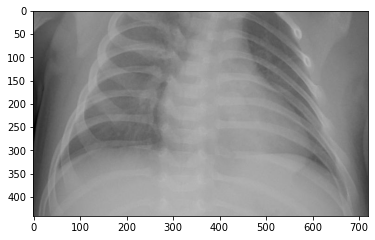

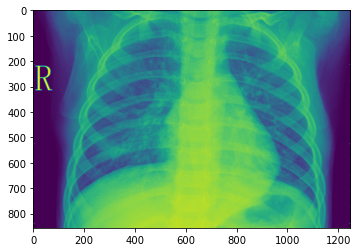

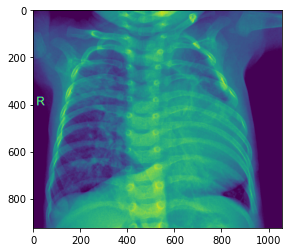

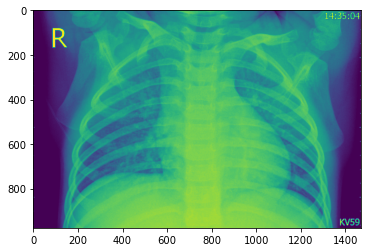

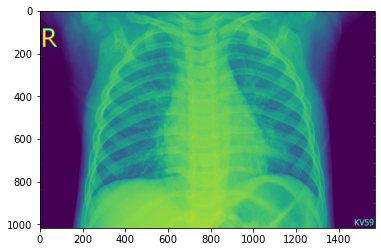

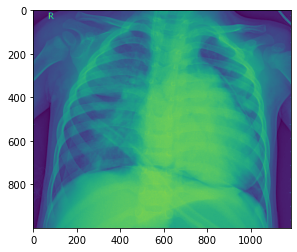

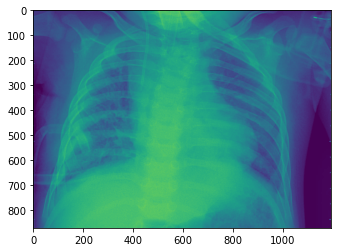

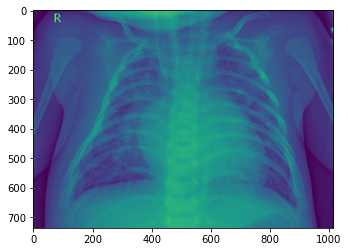

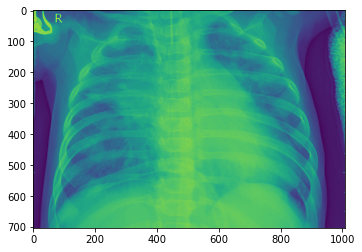

In [5]:
df = positive.head(20)
show_images(df)

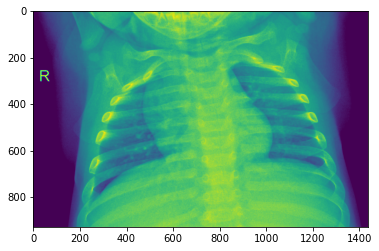

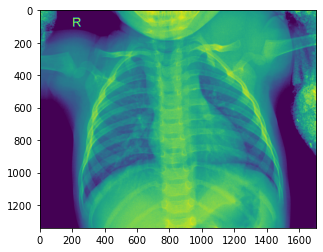

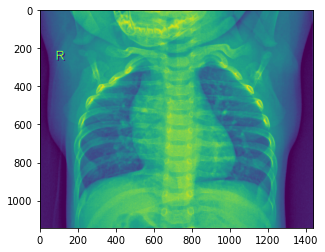

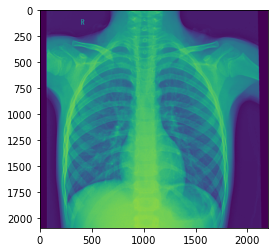

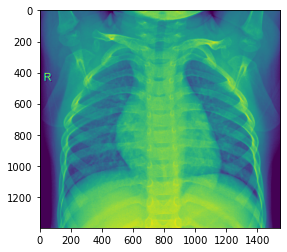

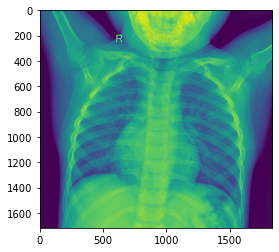

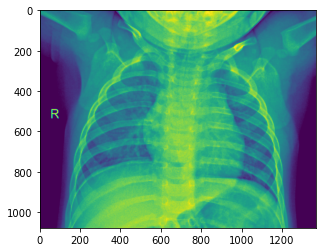

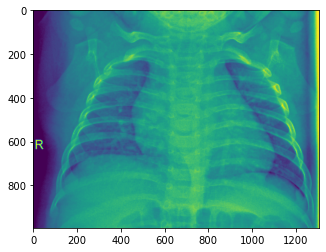

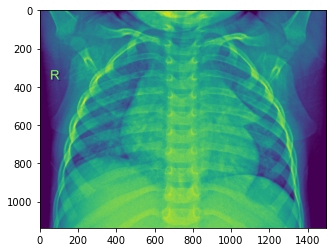

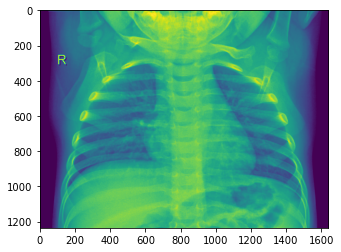

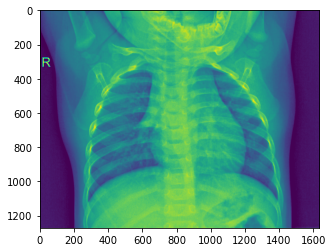

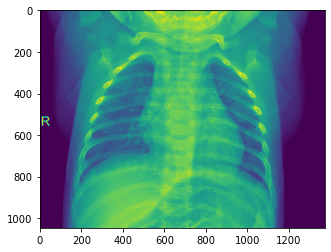

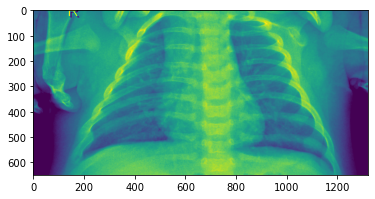

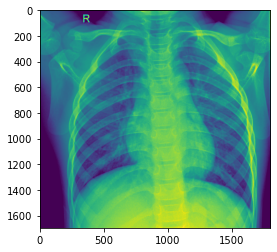

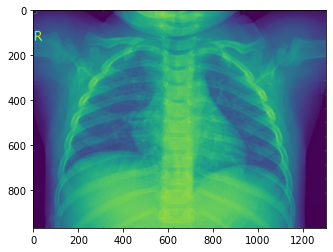

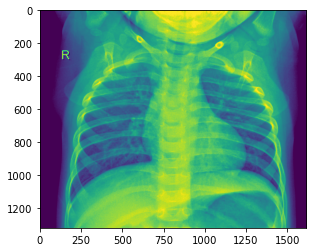

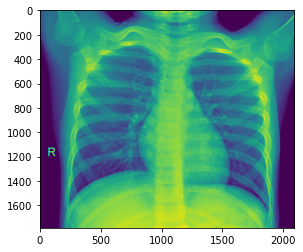

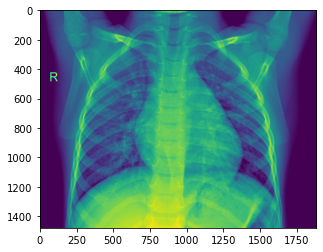

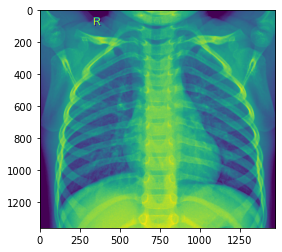

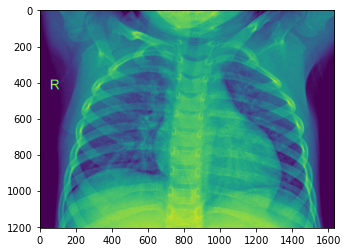

In [6]:
df = negative.head(20)
show_images(df)

In [7]:
df_test = pd.read_csv('/kaggle/input/i2a2-brasil-pneumonia-classification/test.csv')
df_test.head()

fileName
0  ee9a09ba-0e24-4536-91d9-04d5f21d4056.jpeg
1  a46e7a54-5932-4638-8274-9df141243230.jpeg
2  f67d8ca6-63ea-4217-91d9-d8e9fc13094f.jpeg
3  da12b954-8356-45ba-a7b7-ae05659c0180.jpeg
4  a9e68a83-0c0f-42a5-b516-468b7a18cbe3.jpeg

## Neural network

In [8]:
import numpy as np
import os
import random
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint   
from keras.layers import Conv2D, Dense, Dropout, GlobalMaxPooling2D, MaxPooling2D
from keras.models import Model, Sequential
from keras.preprocessing.image import img_to_array, load_img
from keras.utils import np_utils

from sklearn.model_selection import train_test_split

In [9]:
MODEL_PATH = 'model.pneumonia.weights.best.hdf5'

In [10]:
def init_model():
    if not os.path.isfile(MODEL_PATH):
        model = train()
        print('New train!')
    else:
        model = create_model()
        model.load_weights(MODEL_PATH)
        print('Using network trained!')

    return model

In [11]:
def prepare_dataset(df):
    images = [preprocess_images(f"/kaggle/input/i2a2-brasil-pneumonia-classification/images/{filename}") for filename in df['fileName']]
    images = np.array(images, dtype=np.float32)

    outputs = None
    if 'pneumonia' in df.columns:
        outputs = df['pneumonia']
    
    return images, outputs

def preprocess_images(filename):
    image = load_img(filename, target_size=(256, 256))
    image = img_to_array(image)
    image = image.reshape((image.shape[0], image.shape[1], image.shape[2]))
    return preprocess_input(image) 

In [12]:
def create_model():
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape= (256, 256, 3))
    
    number_of_frozen_layers = 0
    for i, layer in enumerate(base_model.layers):
      if i>=number_of_frozen_layers:
        break
      layer.trainable = False

    x = GlobalMaxPooling2D()(base_model.output)
    x = Dense(16, activation = 'relu')(x)
    x = Dense(1, activation = 'sigmoid')(x)

    model = Model(base_model.input, x)
    model.summary()
    
    return model

In [13]:
def balanced_dataset():
    df_train = pd.read_csv('/kaggle/input/i2a2-brasil-pneumonia-classification/train.csv')
    
    negative = df_train.query('pneumonia == 0')
    positive = df_train.query('pneumonia == 1').sample(n=negative.shape[0])
    
    return pd.concat([positive, negative], ignore_index=True)

In [14]:
def train():
    df_train = balanced_dataset()
    images, outputs = prepare_dataset(df_train)
    
    # divindo dataset de treinamento em treinamento, teste e validação
    seed = 42
    x_train, x_test, y_train, y_test = train_test_split(images, outputs, test_size = 0.20, random_state=seed)
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.20, random_state = seed)

    # normalização
    x_train = x_train.astype('float32')/255
    x_valid = x_valid.astype('float32')/255
    x_test = x_test.astype('float32')/255

    model = create_model()
    model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
    
    checkpointer = [ModelCheckpoint(filepath=MODEL_PATH, save_best_only=True),
                    EarlyStopping(patience= 10)]
    
    aug = ImageDataGenerator(
            rotation_range=20,
            zoom_range=0.15,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.15,
            horizontal_flip=True,
            fill_mode="nearest")
        
    hist = model.fit(
       x=aug.flow(x_train, y_train, batch_size=64),
       epochs=100,
       validation_data=(x_valid, y_valid),
       callbacks=checkpointer)

    # carregando os pesos que geraram a melhor precisão de validação
    model.load_weights(MODEL_PATH)

    # avaliar e imprimir a precisão do teste
    score = model.evaluate(x_test, y_test)
    print('\n', 'Test accuracy:', score[1])
    
    return model

In [15]:
def predict_value(value):
    if value > 0.5:
        return 1
    return 0
    
def execute_prediction(df):
    X, _ = prepare_dataset(df)

    X = X.astype('float32')/255
    model = init_model()

    predictions = model.predict(X)
    predictions = [predict_value(pred) for pred in predictions]
    
    filenames = df['fileName']
    return pd.DataFrame({ "fileName": filenames, "pneumonia": predictions })

In [16]:
df_test = pd.read_csv('/kaggle/input/i2a2-brasil-pneumonia-classification/test.csv')
result_test = execute_prediction(df_test)
result_test.head(10)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

Using network trained!


fileName  pneumonia
0  ee9a09ba-0e24-4536-91d9-04d5f21d4056.jpeg          0
1  a46e7a54-5932-4638-8274-9df141243230.jpeg          0
2  f67d8ca6-63ea-4217-91d9-d8e9fc13094f.jpeg          0
3  da12b954-8356-45ba-a7b7-ae05659c0180.jpeg          0
4  a9e68a83-0c0f-42a5-b516-468b7a18cbe3.jpeg          0
5  8d8ef262-1e4a-4341-8243-e52c95856e1d.jpeg          0
6  5a409835-2a56-4828-b330-954af46cf9c0.jpeg          1
7  961a006c-d78e-4fc1-b109-86ce89d718c5.jpeg          1
8  d6dc034b-9aae-4121-8905-0c4dfcdba77b.jpeg          1
9  a584fa1b-4681-4725-a35f-999e1da71f6e.jpeg          1

In [17]:
df_submission = pd.read_csv('/kaggle/input/i2a2-brasil-pneumonia-classification/sample_submission.csv')
result_submission = execute_prediction(df_submission)
result_submission.head(10)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

Using network trained!


fileName  pneumonia
0  ee9a09ba-0e24-4536-91d9-04d5f21d4056.jpeg          0
1  a46e7a54-5932-4638-8274-9df141243230.jpeg          0
2  f67d8ca6-63ea-4217-91d9-d8e9fc13094f.jpeg          0
3  da12b954-8356-45ba-a7b7-ae05659c0180.jpeg          0
4  a9e68a83-0c0f-42a5-b516-468b7a18cbe3.jpeg          0
5  8d8ef262-1e4a-4341-8243-e52c95856e1d.jpeg          0
6  5a409835-2a56-4828-b330-954af46cf9c0.jpeg          1
7  961a006c-d78e-4fc1-b109-86ce89d718c5.jpeg          1
8  d6dc034b-9aae-4121-8905-0c4dfcdba77b.jpeg          1
9  a584fa1b-4681-4725-a35f-999e1da71f6e.jpeg          1

In [18]:
result_submission.to_csv("results.csv",index=False)